In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import gym
import pylab
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import cv2
import matplotlib.pyplot as plt

In [5]:


def ActorCritic(input_shape, action_space, lr):
    X_input = Input(input_shape)
    X = Flatten(input_shape=input_shape)(X_input)
    X = Dense(512, activation="elu", kernel_initializer='he_uniform')(X)
    action = Dense(action_space, activation="softmax", kernel_initializer='he_uniform')(X)
    value = Dense(1, kernel_initializer='he_uniform')(X)

    Actor = Model(inputs = X_input, outputs = action)
    Actor.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr))

    Critic = Model(inputs = X_input, outputs = value)
    Critic.compile(loss='mse', optimizer=RMSprop(lr=lr))

    return Actor, Critic

In [18]:


class PongActorCritic:
    def __init__(self, env_name):
        # Set params
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = 2 # Set to limiy actions
        self.EPISODES, self.max_average = 10000, -21.0
        self.lr = 0.0001
        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4
        self.states, self.actions, self.rewards = [], [], []
        self.scores, self.episodes, self.average = [], [], []
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        self.image_memory = np.zeros(self.state_size)
        self.avgrewards = []
        # Create Actor-Critic network model
        self.Actor, self.Critic = ActorCritic(input_shape=self.state_size, action_space = self.action_size, lr=self.lr)


    def store(self, state, action, reward):
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)


    def act(self, state):
        ''' Make a decision based on the actor model'''
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        return action

    def discount_rewards(self, reward):
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0:
                running_add = 0
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add
        discounted_r -= np.mean(discounted_r)
        discounted_r /= np.std(discounted_r) 
        return discounted_r

                
    def replay(self):
        ''' Fit model and reset memory'''
        # reshape for training
        states = np.vstack(self.states)
        actions = np.vstack(self.actions)

        # Compute discounted rewards
        discounted_r = self.discount_rewards(self.rewards)

        # Get Critic network predictions
        values = self.Critic.predict(states)[:, 0]
        # Compute advantages
        advantages = discounted_r - values
        # training Actor and Critic networks
        self.Actor.fit(states, actions, sample_weight=advantages, epochs=1, verbose=0)
        self.Critic.fit(states, discounted_r, epochs=1, verbose=0)
        # reset training memory
        self.states, self.actions, self.rewards = [], [], []
    
    def getavg(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        return self.average[-1]


    def Preprocess(self, frame):
        # preprocess frame to 80x80 size
        frame_cropped = frame[35:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # crop
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)
        # convertto RGB
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]
        # convert everything to black and white
        frame_rgb[frame_rgb < 100] = 0
        frame_rgb[frame_rgb >= 100] = 255
        # converting to RGB (OpenCV way)
        #frame_rgb = cv2.cvtColor(frame_cropped, cv2.COLOR_RGB2GRAY)     

        # Change to -1
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        self.image_memory = np.roll(self.image_memory, 1, axis = 0)

        # inserting new frame to free space
        self.image_memory[0,:,:] = new_frame

        # show image frame   
        #self.imshow(self.image_memory,0)
        #self.imshow(self.image_memory,1)
        #self.imshow(self.image_memory,2)
        #self.imshow(self.image_memory,3)
        
        return np.expand_dims(self.image_memory, axis=0)

    def reset(self):
        frame = self.env.reset()
        for i in range(self.REM_STEP):
            state = self.Preprocess(frame)
        return state

    def step(self, action):
        next_state, reward, done, info = self.env.step(action + 2)
        next_state = self.Preprocess(next_state)
        return next_state, reward, done, info
    
    def run(self):
        for e in range(self.EPISODES):
            state = self.reset()
            done, score= False, 0,
            while not done:
                # Actor picks an action
                action = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.step(action)
                self.store(state, action, reward)
                # Update current state
                state = next_state
                score += reward
                if done:
                    average = self.getavg(score, e)
                    # saving best models
                    if average >= self.max_average:
                        self.max_average = average
                    print("episode: {}/{}, score: {}, average: {:.2f}".format(e, self.EPISODES, score, average))

                    self.replay()
                    self.avgrewards.append(average)
        # close environemnt when finish training
        self.env.close()

env_name = 'Pong-v0'


In [20]:
go = PongActorCritic(env_name)
go.run()

episode: 0/10000, score: -21.0, average: -21.00
episode: 1/10000, score: -21.0, average: -21.00
episode: 2/10000, score: -19.0, average: -20.33
episode: 3/10000, score: -20.0, average: -20.25
episode: 4/10000, score: -20.0, average: -20.20
episode: 5/10000, score: -19.0, average: -20.00
episode: 6/10000, score: -18.0, average: -19.71
episode: 7/10000, score: -20.0, average: -19.75
episode: 8/10000, score: -21.0, average: -19.89
episode: 9/10000, score: -21.0, average: -20.00
episode: 10/10000, score: -20.0, average: -20.00
episode: 11/10000, score: -21.0, average: -20.08
episode: 12/10000, score: -19.0, average: -20.00
episode: 13/10000, score: -18.0, average: -19.86
episode: 14/10000, score: -20.0, average: -19.87
episode: 15/10000, score: -21.0, average: -19.94
episode: 16/10000, score: -19.0, average: -19.88
episode: 17/10000, score: -21.0, average: -19.94
episode: 18/10000, score: -18.0, average: -19.84
episode: 19/10000, score: -20.0, average: -19.85
episode: 20/10000, score: -20.

KeyboardInterrupt: ignored

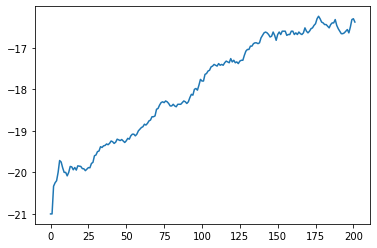

In [21]:
plt.plot(go.avgrewards)

#Stopping early because of google colab limitations. It appears to be flatlining around 16.
# The model is somewhat simple, a more complex NN could probably achieve better performance.